In [1]:
from pymongo import MongoClient
import pandas as pd

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [2]:
sp1041 = pd.read_csv('1041SP_w9.csv')
sp1041.fillna(0.0, inplace=True)
sp1041 = sp1041.drop(['name'], axis=1)
sp1041 = sp1041.drop(['username'], axis=1)
sp1041 = sp1041.drop(['final_score'], axis=1)
sp1041 = sp1041.drop(['label_2'], axis=1)
list(sp1041)

['video_watching_days',
 'video_watching_times',
 'video_watching_total_time',
 'bbs_days',
 'bbs_num',
 'video_watching_num',
 'video_time_between_start_first_watching',
 'pre_watching_num',
 'in_watching_num',
 're_watching_num',
 'no_watching_num',
 'post_watching_num',
 'online_quiz',
 'online_hw',
 'pgm',
 'quiz',
 'adjust_score']

In [3]:
data=sp1041
data['class']=data['adjust_score'] < 60
data=data.drop(['adjust_score'],axis=1)

In [4]:
data

,video_watching_days,video_watching_times,video_watching_total_time,bbs_days,bbs_num,video_watching_num,video_time_between_start_first_watching,pre_watching_num,in_watching_num,re_watching_num,no_watching_num,post_watching_num,online_quiz,online_hw,pgm,quiz,class
0,3,4,0,5,19,1,90,0,0,0,24,0,300,220,96,40,True
1,20,90,6394,1,27,38,506,1,6,2,18,10,200,180,66,60,False
2,12,54,1039,4,4,31,604,0,15,3,9,6,300,250,0,64,False
3,14,132,1061,12,21,59,526,0,11,7,13,11,295,210,68,64,False
4,13,42,1458,1,1,27,622,0,4,3,20,3,180,50,75,40,True
5,3,9,114,6,14,5,101,0,0,0,24,0,200,80,96,28,False
6,8,32,170,8,8,20,353,0,6,2,18,1,300,140,98,88,False
7,4,13,543,0,0,10,194,0,0,0,24,6,100,50,76,60,True
8,5,82,743,0,0,45,288,1,0,0,24,22,200,40,74,56,False
9,5,13,8,1,1,8,273,0,1,0,23,0,100,50,0,52,True


In [5]:
# Import some data to play with
#iris = datasets.load_iris()

#kyoto_y = kyoto_1['score']
#kyoto_x = kyoto_1.drop(['score'], axis=1)

X = data.drop(['class'], axis=1)
y = data['class']
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

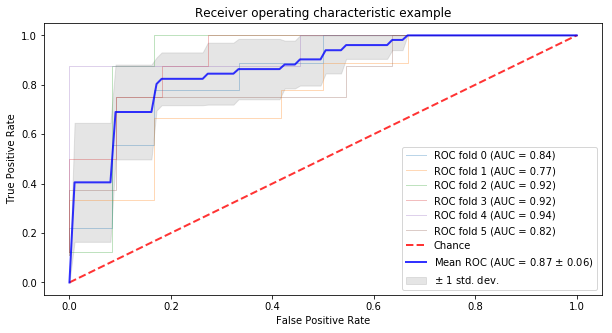

In [6]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 5))

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()